# Lab 2: Sentence Similarity Analysis

Lab session by:
* Daniel Hess
* Pandelis Laurens Symeonidis

### Imports

In [64]:
import nltk
import pandas as pd
from nltk.corpus import stopwords
from nltk.metrics.distance import jaccard_distance
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import numpy as np


### Data Loading

In [65]:
# Load data
dt = pd.read_csv('./STS.input.SMTeuroparl.txt',sep='\t',header=None)
gold_standard_dt = pd.read_csv('./STS.gs.SMTeuroparl.txt',sep='\t',header=None)

# Download corpus
nltk.download('punkt_tab', quiet=True)
nltk.download('stopwords', quiet=True)

True

### Preprocessing function

In [66]:
# Tokenize and option to make sentences all lower and/or removal of SW for analysis
def preprocess_sentences(sentences, lowercase=False, remove_stopwords=False): 
    sw = set(stopwords.words('english'))
    processed = []
    for s in sentences:
        tokens = nltk.word_tokenize(s)
        if lowercase:
            tokens = [t.lower() for t in tokens]
        if remove_stopwords:
            tokens = [t for t in tokens if t.lower() not in sw]
        processed.append(tokens)
    return processed

### Similarity evaluation

In [67]:
# Calculate jaccard distance for each sentence pair and  Pearson coefficient between similarity scores and gold standard
def evaluate_similarity(dt, lowercase=False, remove_stopwords=False):
    sent1 = preprocess_sentences(dt[0], lowercase, remove_stopwords)
    sent2 = preprocess_sentences(dt[1], lowercase, remove_stopwords)

    jaccard_distances = [
        jaccard_distance(set(s1), set(s2)) for s1, s2 in zip(sent1, sent2) 
    ]
    similarity_scores = [1 - d for d in jaccard_distances]

    corr = pearsonr(similarity_scores, gold_standard_dt[0])[0] # Calculate Pearson coefficient between similarity scores and gold standard
    return similarity_scores, corr

### Run cases

In [68]:
# Run all scenarios for comparison
similarity_scores_original, corr_original = evaluate_similarity(dt, lowercase=False, remove_stopwords=False)
similarity_scores_lower, corr_lower = evaluate_similarity(dt, lowercase=True, remove_stopwords=False)
similarity_scores_stop, corr_stop = evaluate_similarity(dt, lowercase=False, remove_stopwords=True)
similarity_scores_both, corr_both = evaluate_similarity(dt, lowercase=True, remove_stopwords=True)

print("Original correlation:", corr_original)
print("Lowercase correlation:", corr_lower)
print("Stopword removal correlation:", corr_stop)
print("Lowercase + Stopword removal correlation:", corr_both)


Original correlation: 0.4504977169318684
Lowercase correlation: 0.4624951397591497
Stopword removal correlation: 0.4373710526352063
Lowercase + Stopword removal correlation: 0.4451596378377866


### Analysis

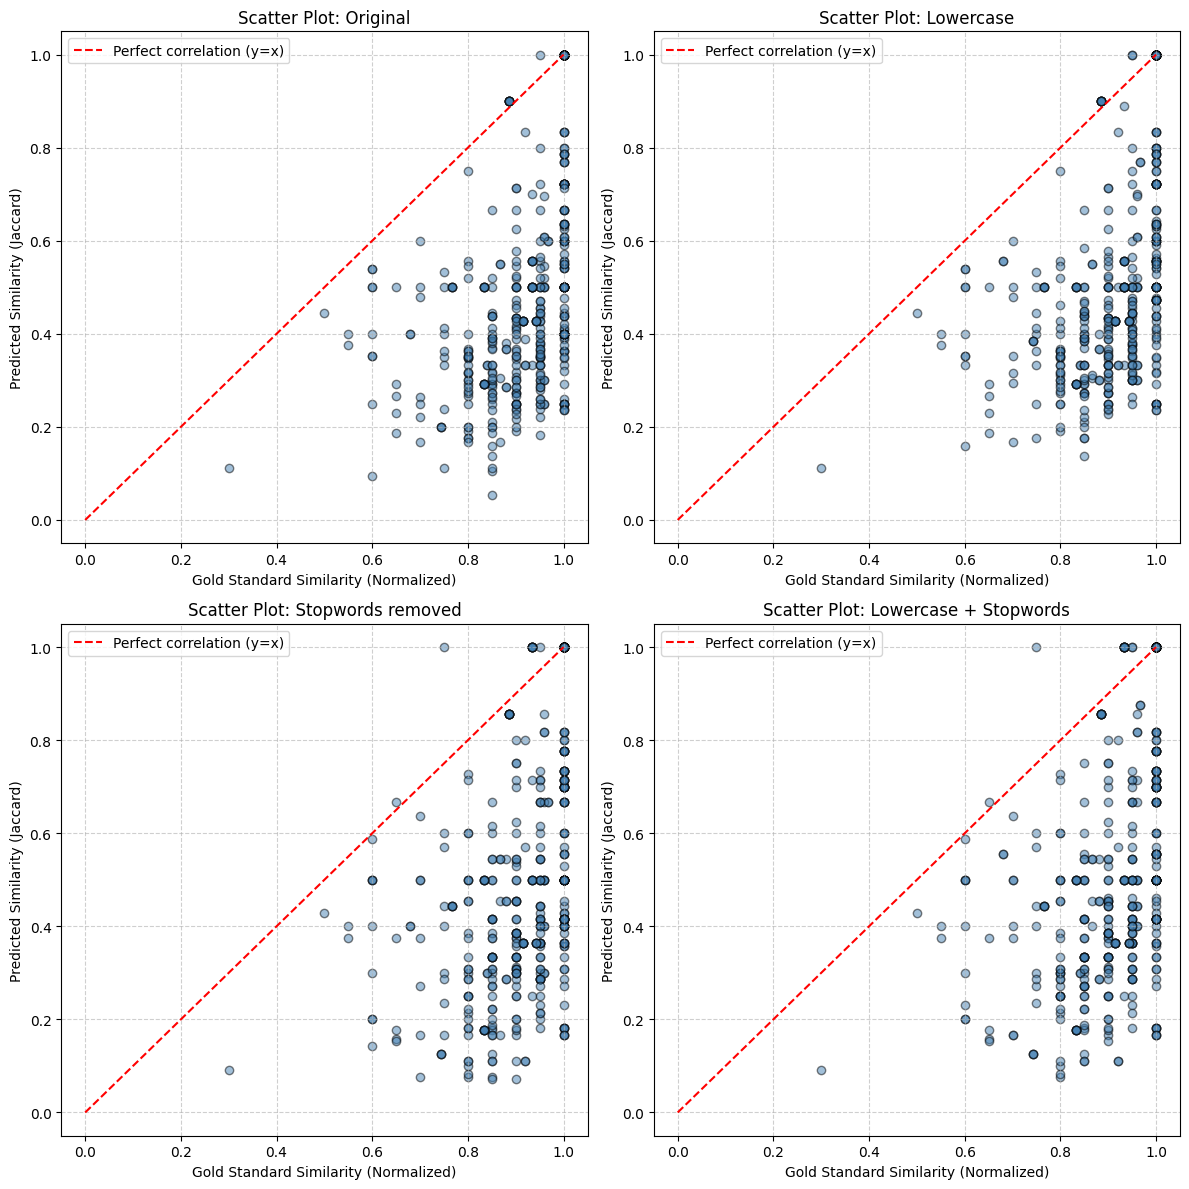

In [69]:
x = (gold_standard_dt[0]/5).values  # gold standard scores
ys = [
    similarity_scores_original,
    similarity_scores_lower,
    similarity_scores_stop,
    similarity_scores_both
] # predicted scores

titles = [
    "Original",
    "Lowercase",
    "Stopwords removed",
    "Lowercase + Stopwords"
]

fig, ax_arr = plt.subplots(2, 2, figsize=(12, 12))

for ax, y, title in zip(ax_arr.ravel(), ys, titles):
    y = np.array(y)  # make sure it's an array
    ax.scatter(x, y, alpha=0.5, color="steelblue", edgecolor="k")
    ax.plot([0, 1], [0, 1], '--', color="red", label="Perfect correlation (y=x)")
    ax.set_xlabel("Gold Standard Similarity (Normalized)")
    ax.set_ylabel("Predicted Similarity (Jaccard)")
    ax.set_title(f"Scatter Plot: {title}")
    ax.legend()
    ax.grid(True, linestyle="--", alpha=0.6)

plt.tight_layout()
plt.show()

The results show that making the sentences lowercase improves the correlation with human similarity judgments slightly (r = 0.462 vs 0.450), which shows that case normalization helps reduce some superficial differences, making the sentence matching slightly more forgiving. On the other hand, stopword removal reduced the correlation (r = 0.437), suggesting that stopwords ("the", "and", "to", etc) still provide useful information for sentence matching similarity measures like Jaccard. Combining both methods yielded performance similar to the baseline (r = 0.445). Overall, this highlights how preprocessing choices can influence evaluation results, even with a simple metric.

As seen from our comparison, the biggest improvement came from turning all tokens into lowercase. This is a common form of normalization, making the similarities be less sensitive to differences in capitalization. Other normalization techniques can bring the predicted similarities even closer to the gold standard by briding the gap between other types of small differences between words. For example, converting the words into their base forms called lemmas or replacing synonyms by their common word. These techniques would be likely to boost the similarity scores however it is always important to know that it can also skew the results, as in some cases some comparisons will be significantly different. 
